In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [34]:
%matplotlib inline

from typing import List, Optional, Callable

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import itertools
import logging
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import xgboost as xgb

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler
from sklearn.neighbors import NearestNeighbors
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

from nf import *
from nf.rejection_sampling import rejection_sampling
import matplotlib.pyplot as plt
from rich_utils.my_roc_auc import my_roc_auc
from rich_utils.plot_distributions import *

In [3]:
! ls ../data/data_calibsample

kaon2_+_down_2016_.csv	muon_+_down_2016_.csv	pion_+_down_2016_.csv
kaon2_+_up_2016_.csv	muon_+_up_2016_.csv	pion_+_up_2016_.csv
kaon2_-_down_2016_.csv	muon_-_down_2016_.csv	pion_-_down_2016_.csv
kaon2_-_up_2016_.csv	muon_-_up_2016_.csv	pion_-_up_2016_.csv
kaon_+_down_2016_.csv	pion2_+_down_2016_.csv	proton_+_down_2016_.csv
kaon_+_up_2016_.csv	pion2_+_up_2016_.csv	proton_+_up_2016_.csv
kaon_-_down_2016_.csv	pion2_-_down_2016_.csv	proton_-_down_2016_.csv
kaon_-_up_2016_.csv	pion2_-_up_2016_.csv	proton_-_up_2016_.csv


## Гиперпараметры

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 2 * 10**5
data_dir = '../data/data_calibsample'
particle = 'kaon'
weight_filed = 'probe_sWeight'
features = ['Brunel_P', 'Brunel_ETA', 'nTracks_Brunel']
dlls = ['RichDLLp', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLbt']
fields = [weight_filed] + features + dlls

cb_params = dict(
    iterations=1000,
    eval_metric='AUC',
    metric_period=100,
    use_best_model=False
)

params = dict(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    min_child_weight=50,
    n_jobs=24
)

## Препроцессинг данных

In [5]:
data = pd.concat([
    pd.read_csv(os.path.join(data_dir, f), sep='\t')[fields]
    for f in os.listdir(data_dir) if particle in f
]).sample(frac=1)
data.head()

,probe_sWeight,Brunel_P,Brunel_ETA,nTracks_Brunel,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt
105821,0.523752,41942.70,3.60126,265,-22.35510,-3.19782,-1.854100,11.11490,-7.39117
115379,0.097168,3481.40,2.79871,319,-3.31828,-15.97660,-5.294300,-3.31828,-3.31828
357412,0.023675,6968.97,3.59546,180,-24.94740,-32.98570,-13.990700,-24.94740,-24.94740
271348,0.795249,24629.10,3.90306,119,10.91010,-1.81534,-1.096670,18.79430,19.87500
310210,1.228310,51833.40,3.79321,339,-17.38100,-1.53089,-0.864424,9.84742,-13.72230


In [6]:
data = data[data.RichDLLe > -998]
data = data[data.RichDLLp != 0.0]
data.shape

(3965223, 9)

In [7]:
X, Y, weights = data[features].values.astype(np.float32), data[dlls].values.astype(np.float32), data[weight_filed].values.astype(np.float32)
train_size = data.shape[0] * 7 // 10

X_train_, Y_train_, w_train = X[: train_size], Y[: train_size], weights[: train_size]
X_val_, Y_val_, w_val = X[train_size :], Y[train_size :], weights[train_size :]
X_train_.shape, X_val_.shape

((2775656, 3), (1189567, 3))

In [8]:
class DataPreprocessor:
    def __init__(self):
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

    def fit(self, X, Y):
        self.y_scaler.fit(Y)
        self.x_scaler.fit(np.log(X + 1))
        return self
    
    def transform(self, X, Y):
        return self.x_scaler.transform(np.log(X + 1)), self.y_scaler.transform(Y)
    
    def inverse_transform(self, X, Y):
        return np.exp(self.x_scaler.inverse_transform(X)) - 1, self.y_scaler.inverse_transform(Y)

In [9]:
preprocessor = DataPreprocessor().fit(X_train_, Y_train_)
X_train, Y_train = preprocessor.transform(X_train_, Y_train_)
X_val, Y_val = preprocessor.transform(X_val_, Y_val_)

In [10]:
X_train_tensor = torch.from_numpy(X_train.astype(np.float32)).to(device)
X_test_tensor = torch.from_numpy(X_val.astype(np.float32)).to(device)
Y_train_tensor = torch.from_numpy(Y_train.astype(np.float32)).to(device)
Y_test_tensor = torch.from_numpy(Y_val.astype(np.float32)).to(device)

In [11]:
def get_data_generator(X, Y, batch_size):
    assert(len(X) == len(Y))
    while True:
        for i in range(0, len(X), batch_size):
            yield (Y[i: i + batch_size], X[i: i + batch_size])

data_gen = get_data_generator(X_train_tensor, Y_train_tensor, batch_size)

## Модель
10 слоев АктНорм + МАФ с денснетом  
Прайор нормальный с обучаемыми средним и дисперсием(завсят от кондишна)  
Оптимайзер адам

In [12]:
dim, cond_dim = len(dlls), len(features)

flows = []
for i in range(10):
    flows.append(ActNorm(dim=dim).to(device))
    flows.append(ConditionalMAF(dim, cond_dim, hidden_dim=[8, 8, 8, 8], base_network=Densnet).to(device))

prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = ConditionalNormalizingFlowModel(dim, cond_dim, prior, flows).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
metrics_ll_train, metrics_ll_test = [], []
step_freq = 200
best_loss = 2.5

In [13]:
! mkdir model_densnet_10_without_clip_kaon

## Обучение

2.8333155870437623


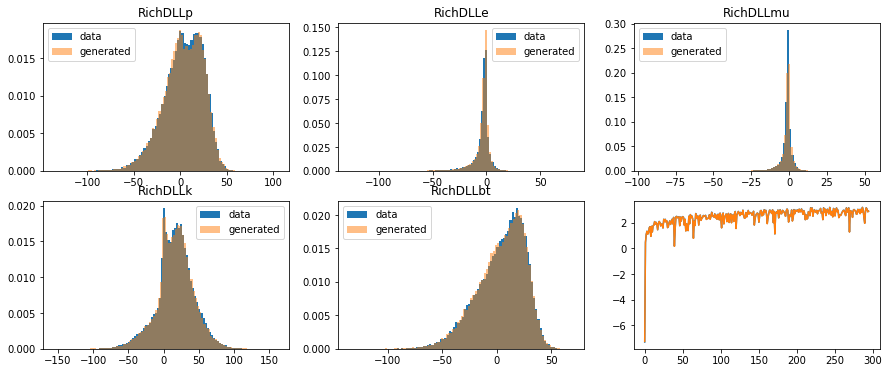

KeyboardInterrupt: 

In [14]:
epoches = 100000
n_samples = 50000
for i in range(step_freq * len(metrics_ll_train), epoches):
    model.train()
    optimizer.zero_grad()
    Y_batch, X_batch = next(data_gen)
    z, logp_z, log_det = model(Y_batch, X_batch)
    logp_x = logp_z + log_det
    loss = -torch.mean(logp_x)
    loss.backward()
#     torch.nn.utils.clip_grad_value_(model.parameters(), 10.0)
    optimizer.step()

    if i % step_freq == 0:
        model.eval()
        with torch.no_grad():
            metrics_ll_train.append(torch.mean(
                model.log_prob(Y_train_tensor[:n_samples], X_train_tensor[:n_samples])
            ).item())
            metrics_ll_test.append(torch.mean(
                model.log_prob(Y_test_tensor[:n_samples], X_test_tensor[:n_samples])
            ).item())
            
            samples = model.sample(
                X_test_tensor[:n_samples],
                batch_size=n_samples,
                post_map=preprocessor.y_scaler.inverse_transform
            )
        
        if metrics_ll_train[-1] > best_loss:
            best_loss = metrics_ll_train[-1]
            torch.save(model.state_dict(), f'model_densnet_10_without_clip_kaon/best_model')
            torch.save(optimizer.state_dict(), f'model_densnet_10_without_clip_kaon/best_optim')

        clear_output(True)
        print(np.mean(metrics_ll_train[-10:]))
        fig, axs = plt.subplots(2, 3, figsize=(15, 6))
        
        axs[1, 2].plot(metrics_ll_train)
        axs[1, 2].plot(metrics_ll_test)

        for i in range(dim):
            axs[i // 3, i % 3].hist(Y_val_[:n_samples, i], 100, label="data", density=True)
            axs[i // 3, i % 3].hist(samples[:, i], 100, label="generated", density=True, alpha=0.5)
            axs[i // 3, i % 3].legend()
            axs[i // 3, i % 3].set_title(dlls[i])
        
        plt.show()

In [16]:
# ! ls model_densnet_10_without_clip

In [18]:
# model.load_state_dict(torch.load('model_densnet_10_without_clip/best_model'))

<All keys matched successfully>

## Визуализация полученных данных

In [15]:
samples = model.sample(
    X_test_tensor,
    post_map=preprocessor.y_scaler.inverse_transform
)

d1 = pd.DataFrame(np.hstack([Y_val_, X_val, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_val, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsReal'] = True
d2['IsReal'] = False
d2.head()

/home/user/miniconda3/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
0,-19.493484,-17.774717,-5.033935,-19.437525,-19.479906,-0.295355,1.869632,-0.061189,-0.502756,False
1,-64.502136,-2.073274,-1.214680,14.964850,-58.128307,0.831734,-0.120317,-1.672312,1.184170,False
2,17.009592,0.603661,1.044029,5.607215,0.846106,0.811687,1.677406,-0.553607,1.188320,False
3,12.545613,-16.975800,-10.328473,12.520916,12.539334,-1.793287,-1.564816,1.772956,0.000758,False
4,10.352583,-3.801136,-1.680977,32.809380,25.558838,0.413377,-1.851889,-1.408498,0.416763,False


## Попарные распределения таргетов

### Реальные данные

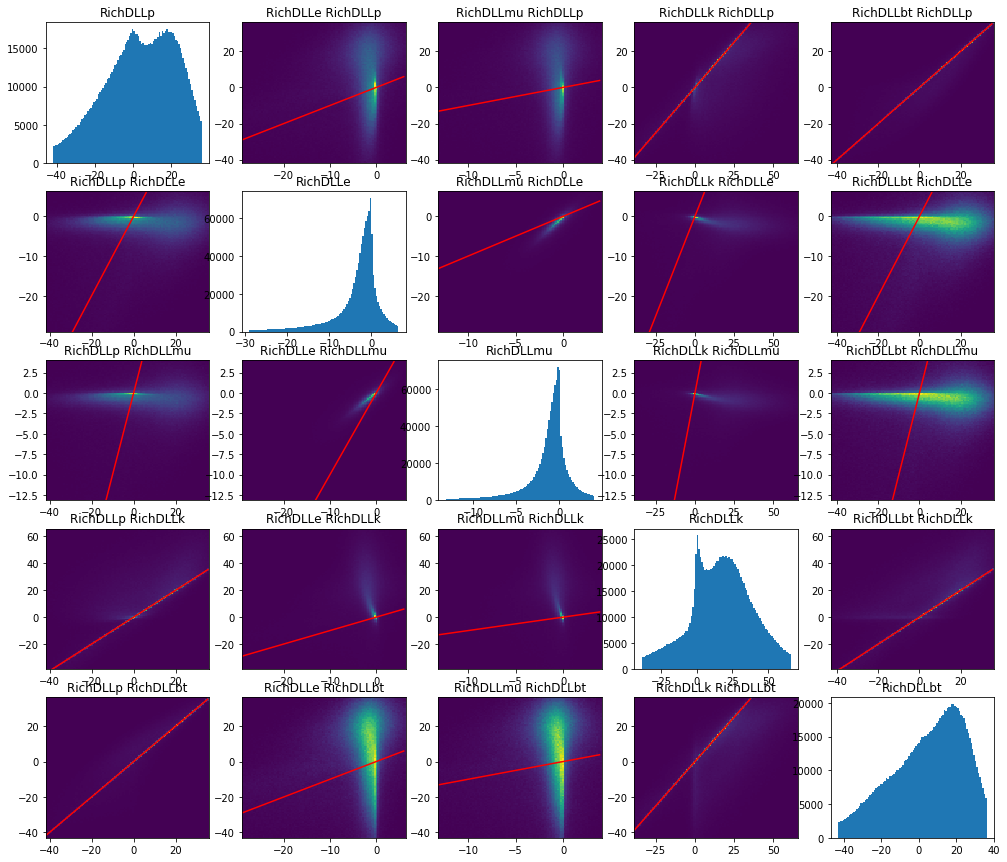

In [16]:
plot_joint_dll_distributions(d1, dlls)

### Сгенерированные данные

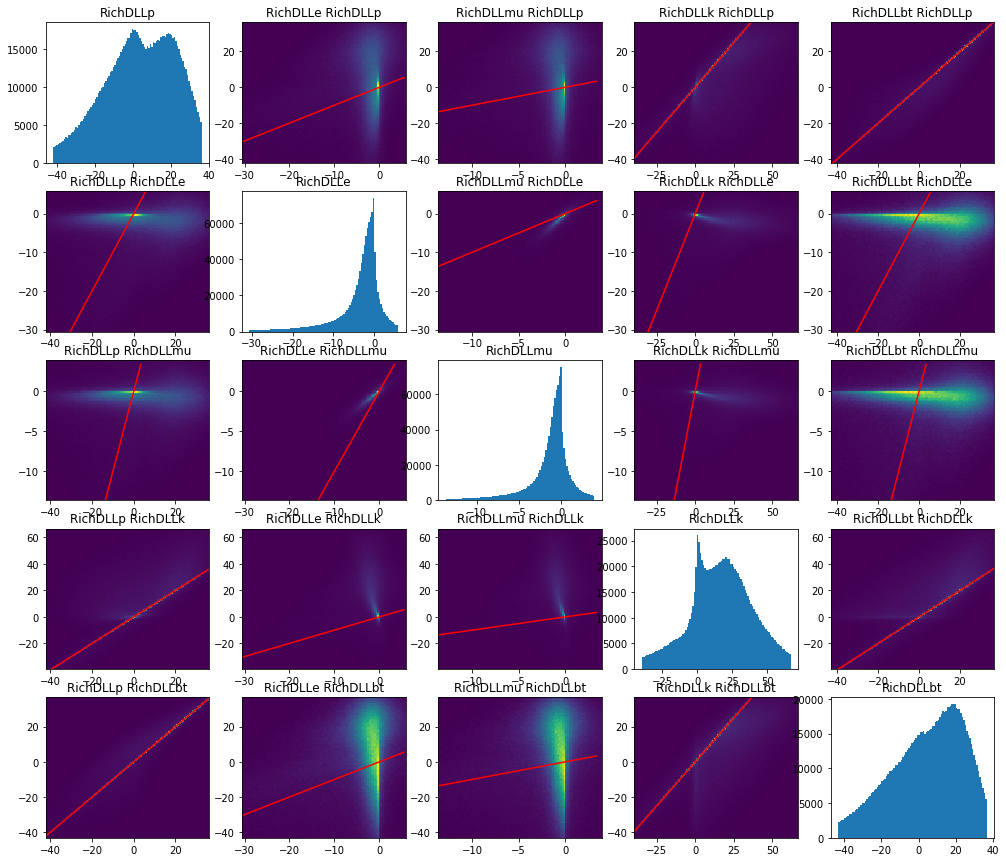

In [17]:
plot_joint_dll_distributions(d2, dlls)

## Попарные распределения таргетов и кондишнов

### Реальные данные

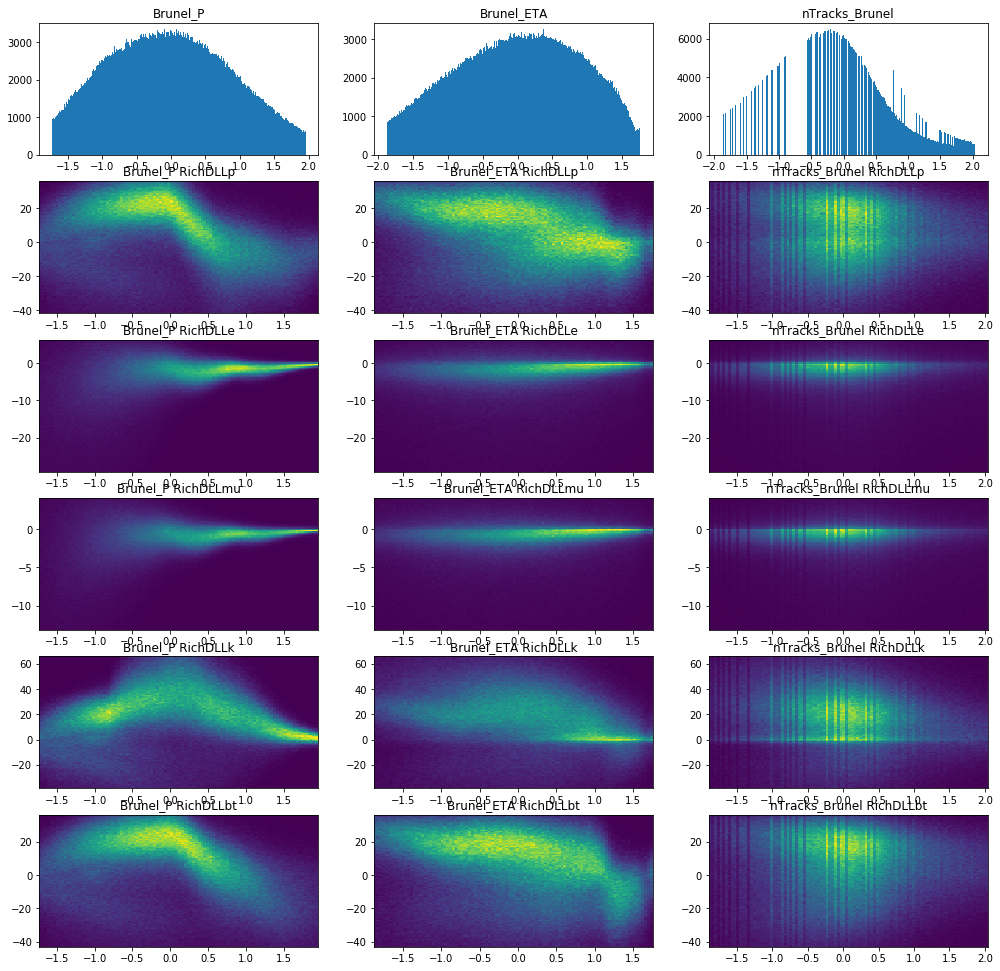

In [18]:
plot_joint_cond_dll_distributions(d1, dlls, features)

### Сгенерированные данные

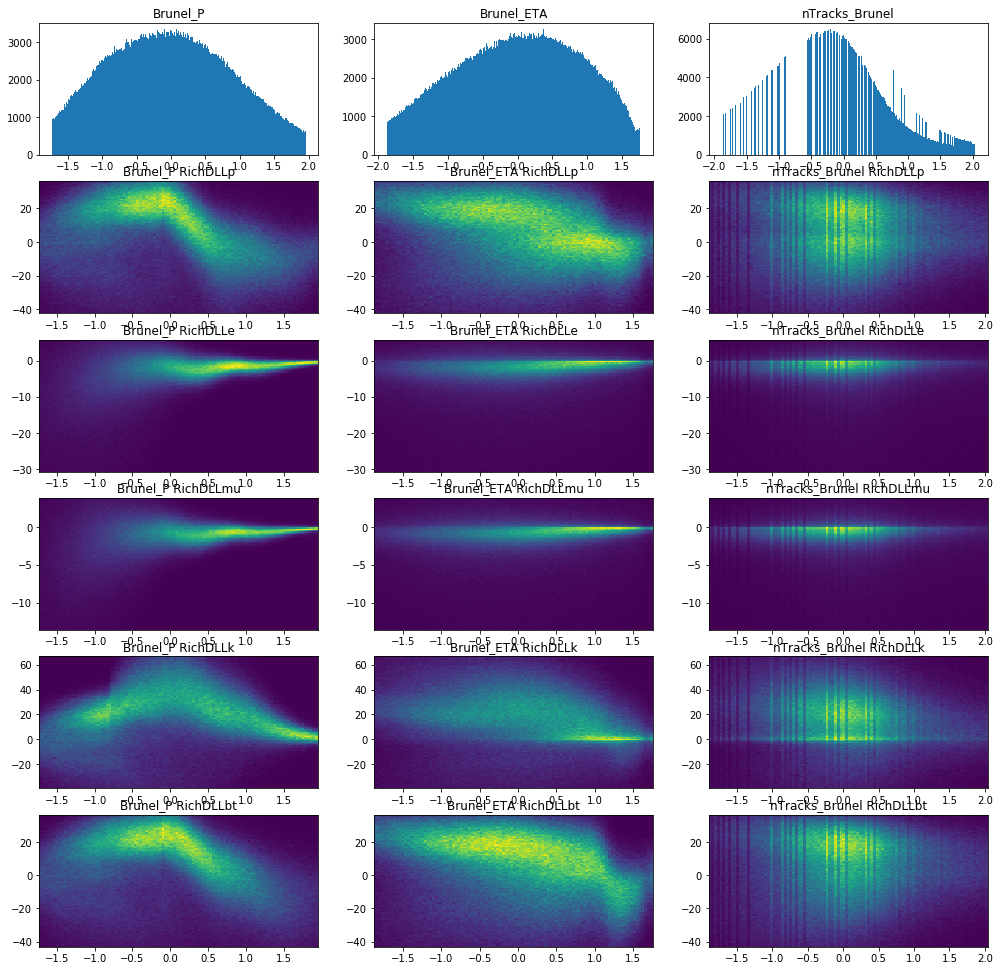

In [19]:
plot_joint_cond_dll_distributions(d2, dlls, features)

## Обучение xgboost для подсчета метрик

In [20]:
classification_ds = pd.concat([d1, d2]).sample(frac=1)
classification_ds.head(10)

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
1143508,15.620500,-1.922630,-1.042030,34.691502,16.644400,-0.090989,-1.129585,0.974080,1.110840,True
740214,-27.820967,-32.783108,-5.461349,-27.732801,-27.670090,-1.056664,-0.912885,1.445453,1.202810,False
844942,-36.209702,-17.910101,-1.442510,-37.580502,-36.209702,-0.740686,-1.260633,-0.028049,0.395830,True
272662,32.446999,-0.622929,-0.245556,41.636700,32.446999,-0.565997,-1.440088,-0.798715,0.459950,True
316369,6.214830,-5.597690,-6.902070,6.214830,6.214830,-1.206043,0.101147,0.839226,-0.144004,True
1047878,-6.848450,-5.690480,-3.599640,35.717899,8.143750,0.259764,-0.829737,-0.750320,0.004162,True
21838,9.138181,-4.758788,-2.172715,23.944984,9.119122,-0.149954,0.631176,0.169564,1.154050,False
1107892,-7.733370,-1.800820,-1.244720,16.296700,-0.056789,0.961462,-0.299644,0.366720,1.162290,True
651676,37.629200,-2.786870,1.490030,40.616001,37.629200,-0.799395,-1.021890,-0.175964,0.064382,True
752619,22.462793,-2.484237,-1.083739,14.488704,29.267527,0.257091,0.722012,0.208705,1.077130,False


In [21]:
n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]
cls_train.shape, cls_val.shape

((1665393, 10), (713741, 10))

In [22]:
xgb_model = xgb.XGBClassifier(**params)

In [23]:
xgb_model.fit(
    X=cls_train[dlls + features].values,
    y=cls_train['IsReal'].values.astype('int32'),
)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=24, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [24]:
is_gen_pred = xgb_model.predict(cls_val[dlls + features].values)
is_gen_pred_probas = xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1]
is_gen_true = cls_val['IsReal'].values
cls_weights = cls_val[weight_filed].values

In [25]:
print('Accuracy =', np.sum(is_gen_pred == is_gen_true) / len(is_gen_pred))
print('ROC AUC =', roc_auc_score(is_gen_true, is_gen_pred_probas))
print('Weighted AUC ROC =', my_roc_auc(is_gen_true, xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1], cls_weights))

Accuracy = 0.533388161812198
ROC AUC = 0.5506326523187337
Weighted AUC ROC = 0.5676839387759814


## Обучение catboost для калибрации

In [26]:
samples = model.sample(
    X_train_tensor,
    post_map=preprocessor.y_scaler.inverse_transform
)
d1 = pd.DataFrame(np.hstack([Y_train_, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_train, w_train.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsReal'] = True
d2['IsReal'] = False

classification_ds = pd.concat([d1, d2]).sample(frac=1)

n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]

cls_train.head(10)

/home/user/miniconda3/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
2537074,-39.058998,-6.812280,-2.322010,-54.525398,-39.058998,-0.365257,-1.247919,1.031817,-1.036260,True
358632,19.643480,-0.871763,0.510114,39.946648,20.144762,0.021916,-0.574575,0.941240,0.765305,False
1556332,-25.171133,-4.795714,-2.089355,27.212477,-4.547389,0.508929,-2.274379,1.224140,1.241280,False
1881128,1.199840,-0.189007,-0.079837,1.735190,-26.643999,2.200611,1.290512,-0.612024,0.785244,True
17249,34.280300,-0.145782,0.557861,65.558098,34.280300,-0.393206,-0.267841,0.625234,1.291700,True
1889878,16.134888,0.709703,-0.275112,33.774307,13.131194,-0.017680,-1.707807,-0.211772,1.218190,False
1418059,15.731400,-1.168200,-1.610090,34.500999,21.189400,0.311422,-0.304470,1.414611,0.812359,True
1926818,3.894410,-16.584999,-2.225360,5.070940,3.894410,-0.824007,0.008725,0.803985,0.836484,True
2302288,13.907100,-4.093530,-1.452570,34.901100,15.694400,0.173968,-0.019913,0.504466,-0.434039,True
2554219,14.122300,-4.261930,-2.787240,14.122300,14.122300,-1.039563,-0.455616,0.999955,1.297040,True


In [27]:
clf = CatBoostClassifier(
    **cb_params
).fit(
    cls_train[dlls + features].values,
    cls_train['IsReal'].values.astype('int32'),
    eval_set=(
        cls_val[dlls + features].values,
        cls_val['IsReal'].values.astype('int32'),
    )
)

Learning rate set to 0.351275
0:	test: 0.5170877	best: 0.5170877 (0)	total: 478ms	remaining: 7m 57s
100:	test: 0.5528168	best: 0.5528168 (100)	total: 22.8s	remaining: 3m 22s
200:	test: 0.5603380	best: 0.5603380 (200)	total: 44.8s	remaining: 2m 57s
300:	test: 0.5646167	best: 0.5646167 (300)	total: 1m 6s	remaining: 2m 33s
400:	test: 0.5675561	best: 0.5675561 (400)	total: 1m 28s	remaining: 2m 11s
500:	test: 0.5701692	best: 0.5701692 (500)	total: 1m 49s	remaining: 1m 49s
600:	test: 0.5722806	best: 0.5722806 (600)	total: 2m 11s	remaining: 1m 27s
700:	test: 0.5738261	best: 0.5738261 (700)	total: 2m 33s	remaining: 1m 5s
800:	test: 0.5752069	best: 0.5752069 (800)	total: 2m 56s	remaining: 43.8s
900:	test: 0.5760778	best: 0.5760778 (900)	total: 3m 18s	remaining: 21.8s
999:	test: 0.5769108	best: 0.5769108 (999)	total: 3m 40s	remaining: 0us

bestTest = 0.5769108168
bestIteration = 999



In [28]:
preds = clf.predict(cls_train[dlls + features], prediction_type='RawFormulaVal')

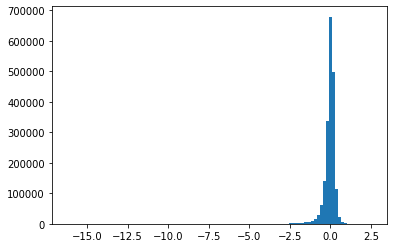

In [30]:
plt.hist(preds[~cls_train['IsReal'].values], bins=100);

In [31]:
clf_wrapper = lambda x: np.clip(clf.predict(x, prediction_type='RawFormulaVal'), -100, np.log(2))

## Обучение xgboost для подсчета метрик после калибрации

In [35]:
samples = rejection_sampling(clf_wrapper, model, 2, X_test_tensor, preprocessor.y_scaler.inverse_transform)
d1 = pd.DataFrame(np.hstack([Y_val_, X_val, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d2 = pd.DataFrame(np.hstack([samples, X_val, w_val.reshape(-1, 1)]), columns=dlls + features + [weight_filed])
d1['IsReal'] = True
d2['IsReal'] = False

n = d1.shape[0]
classification_ds = pd.concat([d1, d2]).sample(frac=1)

n_cls_train = 7 * classification_ds.shape[0] // 10
cls_train = classification_ds[: n_cls_train]
cls_val = classification_ds[n_cls_train :]

cls_train.head(10)

/home/user/miniconda3/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight,IsReal
41376,22.328592,-2.227615,-3.421576,22.266659,22.281830,-1.212901,-1.546213,-0.899311,0.198471,False
781476,14.856795,3.657038,0.293382,14.789968,14.861331,-0.201598,0.611559,0.189233,1.303270,False
746623,25.483315,-5.573684,-2.539448,28.724495,25.484659,-0.710629,-1.952408,-1.023717,1.009740,False
285205,8.958420,-2.787040,-1.405510,26.516701,10.314100,0.179584,-0.083157,1.130376,1.203600,True
1121042,-6.899350,-5.394830,0.502322,-11.594900,-6.899350,-0.506099,0.612602,-0.323371,-0.530446,True
397700,24.639252,-7.067626,-2.776115,20.361113,24.597197,-0.793126,1.225783,2.668705,0.071737,False
731485,0.973930,-13.842400,-12.242200,0.973930,0.973930,-1.339101,0.551904,1.130376,0.040223,True
168168,8.565280,-7.325660,0.233471,8.565280,8.565280,-1.317208,-0.610972,0.512757,1.197880,True
794414,0.916829,-0.026925,-0.009415,-0.037855,23.464487,3.041175,1.099555,-1.805305,1.165040,False
329744,9.018350,-0.122936,0.624657,35.536701,12.878500,0.736160,-0.254748,-1.278496,1.240300,True


In [36]:
xgb_model = xgb.XGBClassifier(**params)

xgb_model.fit(
    X=cls_train[dlls + features].values,
    y=cls_train['IsReal'].values.astype('int32'),
)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=24, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [37]:
is_gen_pred = xgb_model.predict(cls_val[dlls + features].values)
is_gen_pred_probas = xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1]
is_gen_true = cls_val['IsReal'].values
cls_weights = cls_val[weight_filed].values

print('Accuracy =', np.sum(is_gen_pred == is_gen_true) / len(is_gen_pred))
print('ROC AUC =', roc_auc_score(is_gen_true, is_gen_pred_probas))
print('Weighted AUC ROC =', my_roc_auc(is_gen_true, xgb_model.predict_proba(cls_val[dlls + features].values)[:, 1], cls_weights))

Accuracy = 0.5108827992226872
ROC AUC = 0.5187474861645903
Weighted AUC ROC = 0.5143022544057138


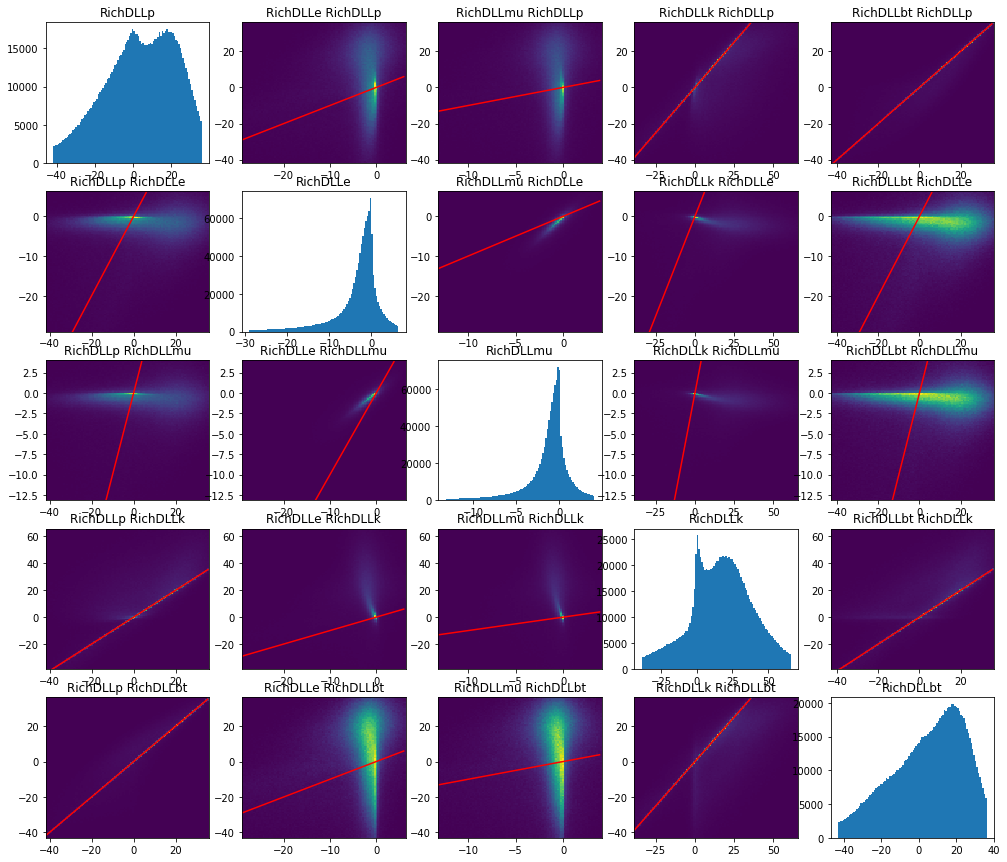

In [38]:
plot_joint_dll_distributions(d1, dlls)

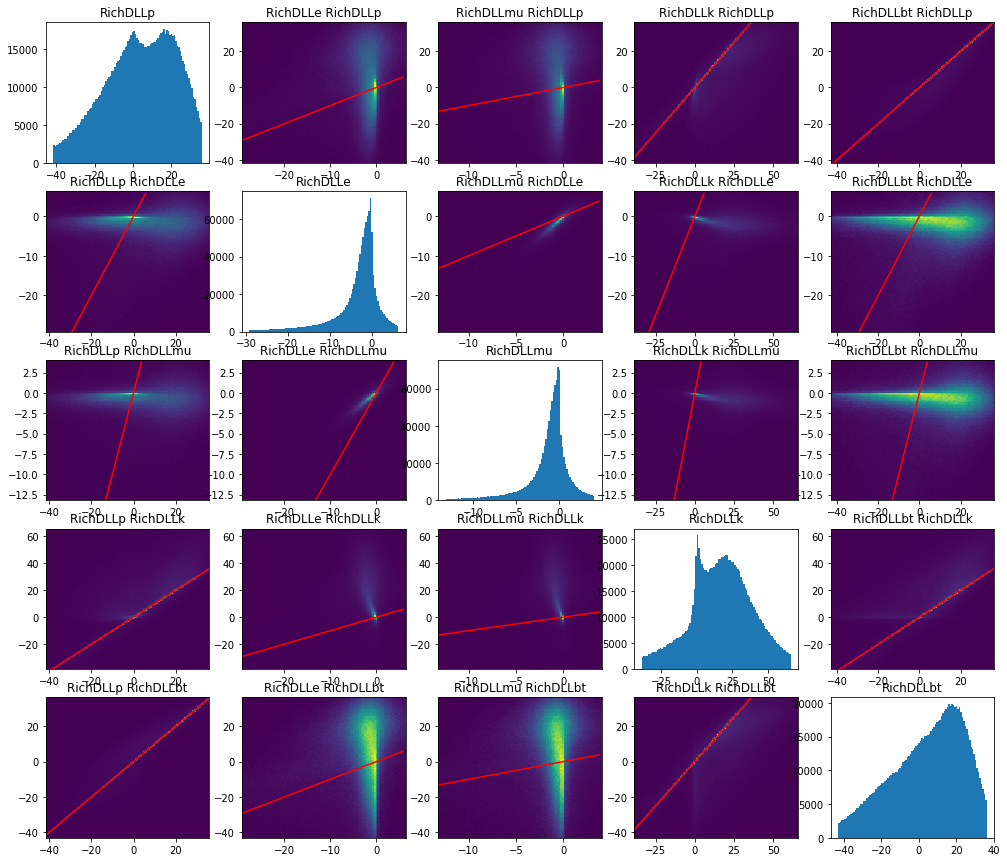

In [39]:
plot_joint_dll_distributions(d2, dlls)

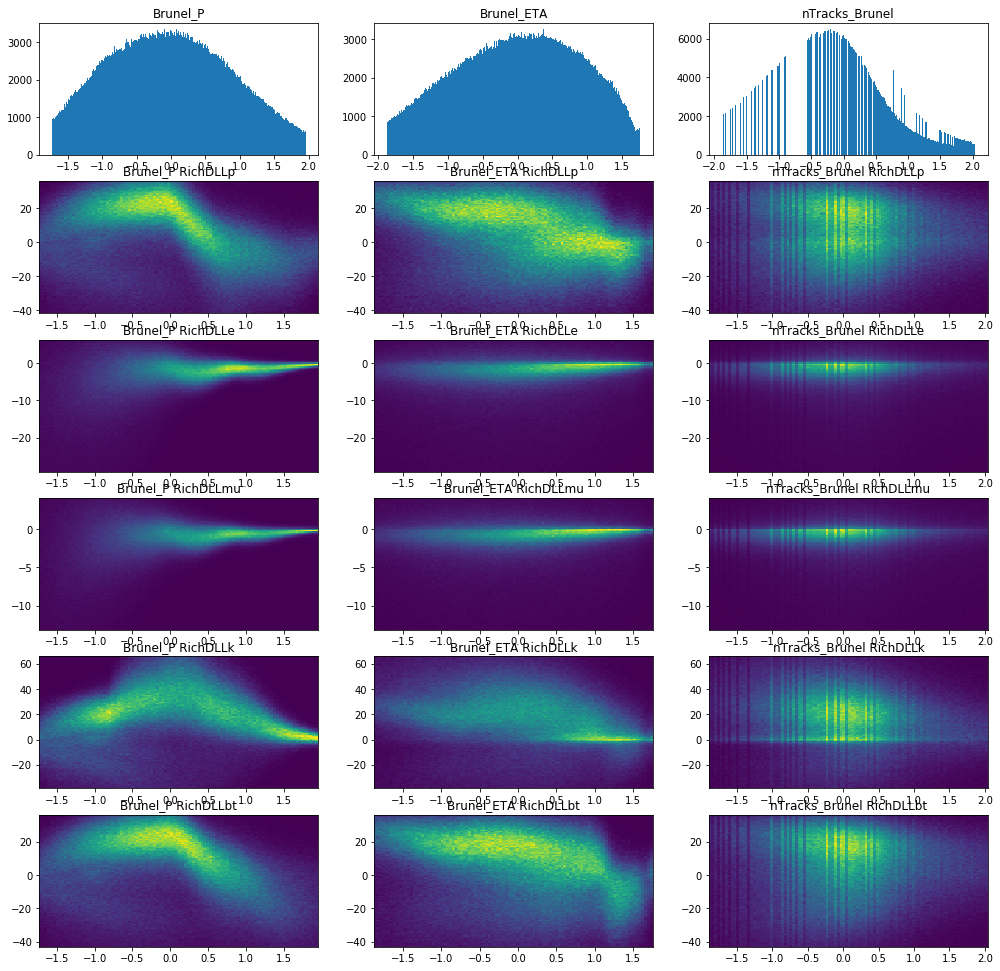

In [40]:
plot_joint_cond_dll_distributions(d1, dlls, features)

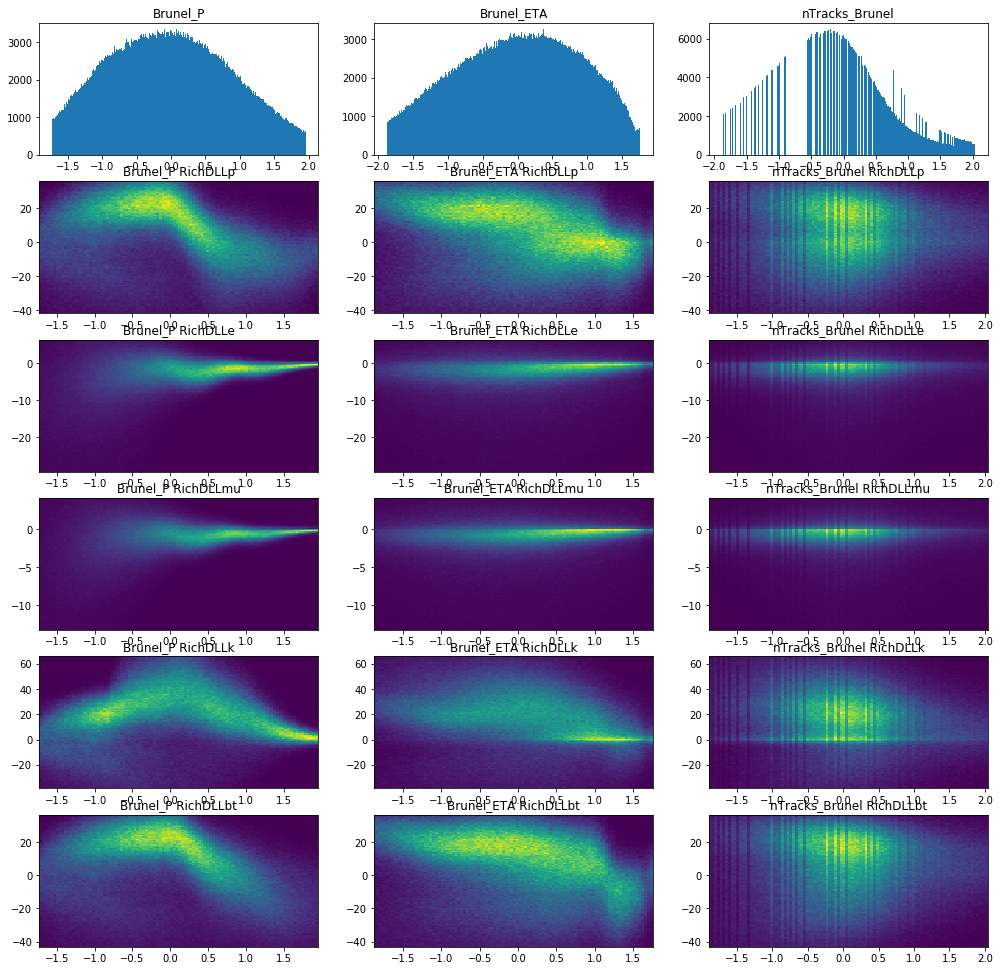

In [41]:
plot_joint_cond_dll_distributions(d2, dlls, features)